# Packages

In [ ]:
import pandas as pd
import os
import numpy as np
import os
import h5py
import torch
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score,confusion_matrix
import matplotlib.pyplot as plt

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_path = './gdrive/MyDrive/Colab Notebooks/MMWAVE_MiinStore/models'
sample_path = './gdrive/MyDrive/Colab Notebooks/MMWAVE_MiinStore/samples'



# Check if the folder exists and create it if it doesn't
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

ensure_directory_exists(model_path)
ensure_directory_exists(sample_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset_path = sample_path + '/mmwave-30frame/'
learning_rate = 1e-4          # 學習率 （可調整）
lstm_hidden_size = 128       # LSTM 隱藏層大小 (可調整)
lstm_num_layers = 2         # LSTM 深度 （可調整）
fc_output_size = 5         # 最終輸出大小（8個分類）
num_epochs = 20           # 訓練次數 （可調整）
training_set = 0.8         # 訓練集比例  90% 剩下為驗證集 （可調整）
my_batch_size = 16      # 批次大小
augment_size = 9 #增強幾個資料
# 要分類的標籤
label_list = ['background', 'turn_left', 'turn_right', 'turn_up', 'turn_down']
# 標籤對應字典
label_map = {label: idx for idx, label in enumerate(label_list)}
label_map_invert = {idx: label for idx, label in enumerate(label_list)}

# CUDA

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Other Function

In [ ]:
# 列出子資料夾
def list_sub(directory_path):
    all_items = os.listdir(directory_path)

    subdirectories = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item))]

    return subdirectories

# 列出所有 h5 的檔案
def list_h5(directory_path):
    all_files = os.listdir(directory_path)

    h5_files = [f for f in all_files if f.endswith('.h5') and os.path.isfile(os.path.join(directory_path, f))]

    return h5_files

# 資料增強
def translate_image(image, max_translate=2):
    # 隨機選擇上下左右移動的像素數
    dx = np.random.randint(-max_translate, max_translate + 1)
    dy = np.random.randint(-max_translate, max_translate + 1)
    return TF.affine(image, angle=0, translate=(dx, dy), scale=1, shear=0)

# 噪聲
def add_noise(image, mean=0, std=0.15):
    # 生成高斯噪聲
    noise = torch.randn(image.size()) * std + mean
    # 加到圖像中
    noisy_image = image + noise

    return noisy_image

# 每幀都要
def augment_frame(frame, max_translate=2):
    frame = translate_image(frame, max_translate)
#     frame = add_noise(frame)
    return frame

# 對整個序列增強
def augment_sequence(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor)
        augmented_sequence.append(augmented_frame.squeeze(0))

    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)
# 對整個序列增強
def augment_sequence_back(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor)
        augmented_frame = add_noise(augmented_frame)
        augmented_sequence.append(augmented_frame.squeeze(0))

    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)
# 對整個序列增強
def augment_sequence_new(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor, max_translate=2)
        augmented_sequence.append(augmented_frame.squeeze(0))

    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)


# Model

In [ ]:
class ConvLSTMNet(nn.Module):
    def __init__(self, lstm_num_layers, lstm_hidden_size, fc_output_size):
        super(ConvLSTMNet, self).__init__()

        # 定義卷積層
        # RDI & PHD 卷積
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 16x16 feature map

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 8x8 feature map

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 4x4 feature map
        )

        # 計算卷積後輸出的特徵圖大小
        # 最終大小為 4x4 , 然後有512個通道
        self.flattened_size = 512 * 4 * 4

        # 定義 LSTM 層
        self.lstm = nn.LSTM(
            input_size = self.flattened_size * 2,
            hidden_size = lstm_hidden_size,
            num_layers = lstm_num_layers,
            batch_first = True
        )

        # 定義全連接層
        self.fc = nn.Linear(lstm_hidden_size, fc_output_size)

    def forward(self, rdi_map, phd_map):
        # 批次大小,  幀數 , 32, 32
        batch_size, timesteps, _, _ = rdi_map.size()

        # 初始化 LSTM 隱藏狀態 並確保他的device跟輸入一樣
        h0 = torch.zeros(lstm_num_layers, batch_size, lstm_hidden_size).to(rdi_map.device)
        c0 = torch.zeros(lstm_num_layers, batch_size, lstm_hidden_size).to(rdi_map.device)

        # 結合兩個Map的卷積結果
        combined_features = []

        for t in range(timesteps):
            rdi_frame = rdi_map[:, t, :, :].unsqueeze(1)  # (batch_size, 1, 32, 32)
            rdi_conv_output = self.conv(rdi_frame)  # (batch_size, 64, 8, 8)
            rdi_conv_output = rdi_conv_output.view(batch_size, -1)  # 攤平 (batch_size, 64*8*8)

            phd_frame = phd_map[:, t, :, :].unsqueeze(1)
            phd_conv_output = self.conv(phd_frame)  # (batch_size, 64, 8, 8)
            phd_conv_output = phd_conv_output.view(batch_size, -1)  # 展平 (batch_size, 64*8*8)

            # 將兩個卷積輸出並在一起
            combined_feature = torch.cat((rdi_conv_output, phd_conv_output), dim=1)  # (batch_size, flattened_size*2)
            combined_features.append(combined_feature)

        # 把所有時間點的特徵結合成一個序列 (batch_size, timesteps, flattened_size*2)
        combined_features = torch.stack(combined_features, dim=1)

        # 把特徵序列輸入到LSTM中
        lstm_out, _ = self.lstm(combined_features, (h0, c0))

        # 取 LSTM 最後的輸出
        lstm_out_last = lstm_out[:, -1, :]


        out = self.fc(lstm_out_last)

        return out


model = ConvLSTMNet(lstm_num_layers, lstm_hidden_size, fc_output_size)
model.to(device)
# 檢查模型結構
print(model)


ConvLSTMNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(16384, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


In [ ]:
print(list_sub(dataset_path))
print(list_h5(dataset_path+list_sub(dataset_path)[4]))
print(dataset_path)

turn_right_path = dataset_path + 'turn_right/' # Assuming dataset_path is already defined



['turn_up', 'background', 'turn_down', 'turn_left', 'turn_right']
['PatPat_0001_2025_05_19_15_50_33.h5', 'PatPat_0002_2025_05_19_15_50_38.h5', 'PatPat_0003_2025_05_19_15_50_42.h5', 'PatPat_0004_2025_05_19_15_50_45.h5', 'PatPat_0005_2025_05_19_15_50_49.h5', 'PatPat_0006_2025_05_19_15_50_53.h5', 'PatPat_0007_2025_05_19_15_50_56.h5', 'PatPat_0008_2025_05_19_15_51_00.h5', 'PatPat_0009_2025_05_19_15_51_03.h5', 'PatPat_0001_2025_05_19_15_51_28.h5', 'PatPat_0002_2025_05_19_15_51_32.h5', 'PatPat_0003_2025_05_19_15_51_35.h5', 'PatPat_0004_2025_05_19_15_51_39.h5', 'PatPat_0005_2025_05_19_15_51_42.h5', 'PatPat_0006_2025_05_19_15_51_45.h5', 'PatPat_0007_2025_05_19_15_51_55.h5', 'PatPat_0001_2025_05_19_15_52_48.h5', 'PatPat_0002_2025_05_19_15_52_52.h5', 'PatPat_0003_2025_05_19_15_52_55.h5', 'PatPat_0004_2025_05_19_15_52_58.h5']
./gdrive/MyDrive/Colab Notebooks/MMWAVE_MiinStore/samples/mmwave-30frame/


# DataLoader

In [ ]:
class MMWaveDataset(Dataset):
    def __init__(self, file_path, dataset_name):
        self.dataItem = []

        # For Background
        with h5py.File(dataset_path + 'background/PatPat_0001_2025_05_19_15_07_23.h5', 'r') as file:
            self.dataItem.append((file[dataset_name][0], file[dataset_name][1],'background'))
            for augment_times in range(augment_size*20):
                augmented_sequence_rdi = augment_sequence_back(file[dataset_name][0])
                augmented_sequence_phd = augment_sequence_back(file[dataset_name][1])
                self.dataItem.append((augmented_sequence_rdi, augmented_sequence_phd, 'background'))


        # For Other gestures
        for gesture_type in list_sub(dataset_path):
            if gesture_type == 'background':
                print('跳過 '+gesture_type)
                continue
            print(gesture_type+":開始生成")
            h5_files = list_h5(dataset_path+gesture_type)
            print(f"{gesture_type} 檔案數量: {len(h5_files)}")
            for filename in h5_files:
                with h5py.File(dataset_path + gesture_type + '/' + filename, 'r') as file:

                    self.dataItem.append((file[dataset_name][0], file[dataset_name][1], gesture_type))
                    augment_size_h = augment_size

                    for augment_times in range(augment_size_h):
                        augmented_sequence_rdi = augment_sequence(file[dataset_name][0])

                        augmented_sequence_phd = augment_sequence(file[dataset_name][1])
                        self.dataItem.append((augmented_sequence_rdi, augmented_sequence_phd, gesture_type))
            print(gesture_type+":生成結束")

    def __len__(self):
        return len(self.dataItem)

    def __getitem__(self, idx):
        rdi_map = self.dataItem[idx][0]
        phd_map = self.dataItem[idx][1]
        target   = self.dataItem[idx][2]
        target = label_map[target]

        if isinstance(rdi_map, torch.Tensor):
            rdi_map = rdi_map.clone().detach().permute(2, 0, 1).to(device)
        else:
            rdi_map = torch.tensor(rdi_map, dtype=torch.float32).permute(2, 0, 1).to(device)

        if isinstance(phd_map, torch.Tensor):
            phd_map = phd_map.clone().detach().permute(2, 0, 1).to(device)
        else:
            phd_map = torch.tensor(phd_map, dtype=torch.float32).permute(2, 0, 1).to(device)

        target = torch.tensor(target, dtype=torch.long).to(device)
        return rdi_map, phd_map, target


dataset = MMWaveDataset(dataset_path, 'DS1')

dataset_size = len(dataset)
train_size = int(training_set* dataset_size)
val_size = dataset_size - train_size
print(dataset_size)
# 分割訓練和驗證集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_batch_size, shuffle=False)

turn_up:開始生成
turn_up 檔案數量: 20
turn_up:生成結束
跳過 background
turn_down:開始生成
turn_down 檔案數量: 20
turn_down:生成結束
turn_left:開始生成
turn_left 檔案數量: 20
turn_left:生成結束
turn_right:開始生成
turn_right 檔案數量: 20
turn_right:生成結束
981


# Loss Function & Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):

    # 訓練部份
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_train_targets = []
    all_train_predictions = []

    for rdi_map, phd_map, targets in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]', unit='batch'):

        outputs = model(rdi_map, phd_map)

        _, predicted_classes = torch.max(outputs, 1)

        all_train_targets.extend(targets.cpu().numpy())
        all_train_predictions.extend(predicted_classes.cpu().numpy())


        correct_predictions += (predicted_classes == targets).sum().item()
        total_samples += targets.size(0)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss/len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    train_f1 = f1_score(all_train_targets, all_train_predictions, average='weighted')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # 驗證部份
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    all_val_targets = []
    all_val_predictions = []

    with torch.no_grad():
        for rdi_map, phd_map, targets in val_loader:
            outputs = model(rdi_map, phd_map)

            _, predicted_classes = torch.max(outputs, 1)

            all_val_targets.extend(targets.cpu().numpy())
            all_val_predictions.extend(predicted_classes.cpu().numpy())

            val_correct_predictions += (predicted_classes == targets).sum().item()
            val_total_samples += targets.size(0)

            loss = criterion(outputs, targets)

            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_samples * 100
    val_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)


    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1-Score: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1-Score: {val_f1:.4f}')


print("Training complete")


Epoch [1/20]: 100%|██████████| 49/49 [00:12<00:00,  3.81batch/s]


Epoch [1/20]
Train Loss: 1.0701, Train Accuracy: 85.71%, Train F1-Score: 0.8592
Validation Loss: 0.6558, Validation Accuracy: 94.42%, Validation F1-Score: 0.9437


Epoch [2/20]: 100%|██████████| 49/49 [00:13<00:00,  3.72batch/s]


Epoch [2/20]
Train Loss: 0.3968, Train Accuracy: 99.36%, Train F1-Score: 0.9936
Validation Loss: 0.1994, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [3/20]: 100%|██████████| 49/49 [00:12<00:00,  3.80batch/s]


Epoch [3/20]
Train Loss: 0.1140, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0638, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [4/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [4/20]
Train Loss: 0.0473, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0337, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [5/20]: 100%|██████████| 49/49 [00:12<00:00,  3.93batch/s]


Epoch [5/20]
Train Loss: 0.0273, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0218, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [6/20]: 100%|██████████| 49/49 [00:12<00:00,  3.93batch/s]


Epoch [6/20]
Train Loss: 0.0181, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0153, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [7/20]: 100%|██████████| 49/49 [00:12<00:00,  3.92batch/s]


Epoch [7/20]
Train Loss: 0.0134, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0120, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [8/20]: 100%|██████████| 49/49 [00:12<00:00,  3.85batch/s]


Epoch [8/20]
Train Loss: 0.0106, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0096, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [9/20]: 100%|██████████| 49/49 [00:12<00:00,  3.86batch/s]


Epoch [9/20]
Train Loss: 0.0087, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0081, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [10/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [10/20]
Train Loss: 0.0073, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0068, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [11/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [11/20]
Train Loss: 0.0063, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0059, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [12/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [12/20]
Train Loss: 0.0054, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0052, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [13/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [13/20]
Train Loss: 0.0048, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0050, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [14/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [14/20]
Train Loss: 0.0043, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0041, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [15/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [15/20]
Train Loss: 0.0038, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0037, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [16/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [16/20]
Train Loss: 0.0035, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0034, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [17/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [17/20]
Train Loss: 0.0032, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0030, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [18/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [18/20]
Train Loss: 0.0029, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0028, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [19/20]: 100%|██████████| 49/49 [00:12<00:00,  3.89batch/s]


Epoch [19/20]
Train Loss: 0.0027, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0026, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [20/20]: 100%|██████████| 49/49 [00:12<00:00,  3.88batch/s]


Epoch [20/20]
Train Loss: 0.0025, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0024, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000
Training complete


# Plot

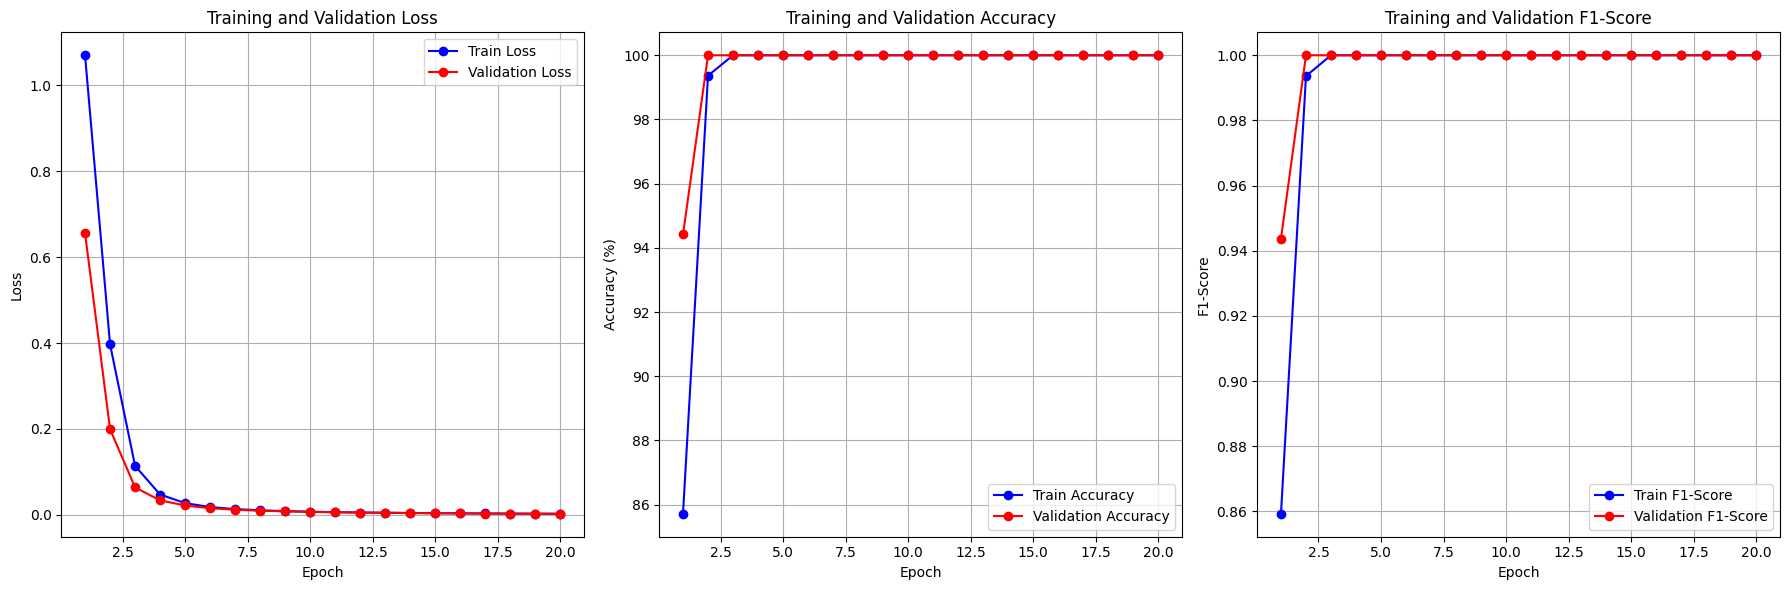

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))

# Loss Graph
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Graph
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# F1-Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_scores, 'bo-', label='Train F1-Score')
plt.plot(epochs, val_f1_scores, 'ro-', label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Model Output (輸出訓練完成的模型)

In [ ]:
model_name = "/mmwave_model_v10_6.pth"
torch.save(model, model_path + model_name)